In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import TokenTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import chain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate ,MessagesPlaceholder
from langchain_classic.memory import ConversationBufferWindowMemory

In [ ]:
#6 주차 
import ast
import requests
import os
import uuid
from typing import Annotated ,TypedDict ,Literal
from langgraph.graph import StateGraph ,START ,END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage ,ToolCall
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode ,tools_condition
from pydantic import BaseModel ,Field
from langgraph.checkpoint.memory import MemorySaver

api_key = os.getenv("OPENWEATHERMAP_API_KEY")

@tool
def calculate(query :str) ->str:
    '''
    수학적 계산을 수행하는 도구입니다.
    '''
    return str(eval(query))

search=TavilySearchResults(k=3)

class WeatherInput(BaseModel):
    city :str =Field(description='날씨를 조회할 도시 이름')
    
@tool(args_schema=WeatherInput)
def get_current_weather(city :str)->str:
    """
    특정 도시의 현재 날씨를 조회
    """
    url=f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric&lang=kr"
    response=requests.get(url)
    data=response.json()
    
    if response.status_code ==200:
        weather_desc =data['weather'][0]['description']
        temp=data['main']['temp']
        return f"{city}의 현재 날씨: {weather_desc} ,온도:{temp}"
    else:
        return f"날씨 조회 실패: {data.get('message' ,'조회 실패')}"
    
tools =[search ,calculate ,get_current_weather]
model =ChatOpenAI(model ='gpt-4o-mini' ,temperature=0).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list ,add_messages]
    
system_prompt =SystemMessage(content="""
당신은 '종합 정보 해결 에이전트'입니다. 
사용자의 요청을 해결하기 위해 [검색], [계산], [날씨] 도구를 전략적으로 사용하여 최적의 답변을 제공하세요.

[도구 사용 원칙]
1. **Weather (날씨)**: "날씨", "기온", "비 오나?" 등의 키워드가 있으면 주저 말고 날씨 도구를 가장 먼저 사용하세요.
2. **Search (검색)**: 최신 정보, 뉴스, 특정 사실 확인이 필요할 때 사용하세요. (단, 3회 이상 반복 검색하지 마세요.)
3. **Calculator (계산)**: 수치 계산이 필요한 경우(예: 환율 계산, 온도 변환, 큰 수의 덧셈 등) 반드시 본인의 암산 대신 계산기 도구를 쓰세요.

**[작업 절차 (Chain of Thought)]**
1. 사용자의 질문을 분석하여 어떤 도구가 필요한지 파악합니다. (복합적인 경우 순서를 정합니다.)
   - 예: "서울 날씨 확인 후 섭씨를 화씨로 변환해줘" -> ①날씨 조회 -> ②계산기 실행
2. 도구를 실행하고 결과를 관찰(Observe)합니다.
3. 결과가 충분하면 최종 답변을 생성하고, 부족하면 다른 도구를 추가로 호출합니다.
**[뉴스 검색 시나리오]**
   - 1단계: 먼저 포괄적인 키워드로 검색하여 최신 뉴스 리스트를 확보하세요.
   - 2단계: 확보된 뉴스 중 **가장 중요하다고 판단되는 하나의 주제를 선정**하세요.
   - 3단계: **반드시** 그 선정된 주제에 대해 **'상세 검색'을 한 번 더 수행**하세요. (이 단계가 누락되면 안 됩니다.)
   - 4단계: 위 정보를 종합하여 **'3가지 뉴스 요약'**과 **'중요 뉴스의 상세 정보'**를 포함한 최종 답변을 작성하세요.

-'상세 정보'를 묻는다면 반드시 추가 검색을 수행하세요.
""")

def plan_node(state:State):
    '''
    계획 수립 및 도구 호출 결정
    '''
    messages=state['messages']
    response=model.invoke([system_prompt]+ messages)
    return {"messages":[response]}

#도구실행
tool_call_node =ToolNode(tools)

def check_result_node(state: State):
    '''
    결과 검증 및 관찰
    '''
    last_message =state['messages'][-1]
    
    if isinstance(last_message ,ToolMessage):
        print(f"\n[Check Result]  도구({last_message.name}) 실행 완료.")
        print(f"   ㄴ 결과 확인: {str(last_message.content)[:200]}...")
    return {"messages" :[]}

def refine_node(state: State):
    '''
    계획 수정 및 재실행 결정
    '''
    last_message = state['messages'][-1]
    if isinstance(last_message, ToolMessage):
        print("[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.")
        
        guidance_msg = SystemMessage(
            content='''
            방금 수행한 검색 결과를 분석하세요.
            1. 만약 단순히 '뉴스 목록'만 있고, 특정 주제에 대한 '깊이 있는 상세 정보'가 부족하다면 **즉시 해당 주제로 다시 검색(Search)** 하세요. (요약 금지)
            2. 만약 '뉴스 목록'과 '상세 정보'가 모두 확보되었다면, 이제 최종 답변을 작성하세요.
            '''
        )
        return {"messages": [guidance_msg]}
    return {"messages":[]}

def tool_first_router(state :State):
    """
    사용자 입력에서 특정 키워드를 감지하여 LLM 없이 즉시 도구를 호출합니다.
    """
    last_msg = state["messages"][-1]
    content = last_msg.content
    
    if "날씨" in content:
        words=content.split()
        city='서울'
        if "날씨" in words:
            idx = words.index("날씨")
            if idx > 0:
                city = words[idx-1]
    
        tool_call_id = str(uuid.uuid4())
        manual_tool_call = ToolCall(
            id=tool_call_id,
            name='get_current_weather',
            args={"city":city},
        )
        return {"messages": [AIMessage(content="", tool_calls=[manual_tool_call])]}
    return {"messages":[]}

def route(state:State):
    last_messages=state['messages'][-1]
    if isinstance(last_messages ,AIMessage) and last_messages.tool_calls:
        return "tool_call_node"
    return "plan_node"

workflow=StateGraph(State)

workflow.add_node("router" ,tool_first_router)
workflow.add_node("plan_node" ,plan_node)
workflow.add_node("tool_call_node" ,tool_call_node)
workflow.add_node("check_result_node" ,check_result_node)
workflow.add_node("refine_node" ,refine_node)

workflow.add_edge(START ,"router")
workflow.add_conditional_edges(
    "router",
    route,
    {
        "tool_call_node": "tool_call_node",
        "plan_node": "plan_node"
    }
)
workflow.add_conditional_edges("plan_node" ,tools_condition ,
    {
        "tools": "tool_call_node",
        END: END
    })
workflow.add_edge("tool_call_node" ,"check_result_node")
workflow.add_edge("check_result_node" ,"refine_node")
workflow.add_edge("refine_node", "plan_node")

memory=MemorySaver()
app=workflow.compile(checkpointer=memory)

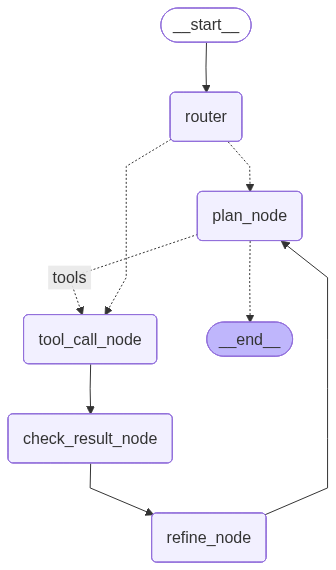

In [17]:
from IPython.display import Image ,display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
config={"configurable" :{"thread_id" :"test1"}}
query = "현재 서울 기온을 검색하고, 그 값에 50을 더해줘."

for event in app.stream({"messages": [HumanMessage(content=query)]}, config=config):
    for node_name, _ in event.items():
        print(f"▶️ 실행된 노드: {node_name}")

▶️ 실행된 노드: router
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: 날씨 조회 실패: city not found...
▶️ 실행된 노드: check_result_node
[Refine Node] 결과를 반영하여 다음 단계를 준비
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: Seoul의 현재 날씨: 맑음 ,온도:3.76...
▶️ 실행된 노드: check_result_node
[Refine Node] 결과를 반영하여 다음 단계를 준비
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(calculate) 실행 완료.
   ㄴ 결과 확인: 53.76...
▶️ 실행된 노드: check_result_node
[Refine Node] 결과를 반영하여 다음 단계를 준비
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node


In [35]:
query = "부산 날씨 알려줘"
config = {"configurable": {"thread_id": "advanced_test_01"}}

print(f"질문: {query}\n" + "="*50)
for event in app.stream({"messages": [HumanMessage(content=query)]}, config=config):
    for node_name, _ in event.items():
        print(f"▶️ 실행된 노드: {node_name}")

질문: 부산 날씨 알려줘
▶️ 실행된 노드: router
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: 날씨 조회 실패: city not found...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: Busan의 현재 날씨: 맑음 ,온도:3.99...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node


In [ ]:
query="최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘"
config ={'configurable': {"thread_id" :'test4'}}
print(f"질문: {query}\n" + "="*50)
for event in app.stream({"messages": [HumanMessage(content=query)]}, config=config):
    for node_name, _ in event.items():
        print(f"▶️ 실행된 노드: {node_name}")

질문: 최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘
▶️ 실행된 노드: router
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(tavily_search_results_json) 실행 완료.
   ㄴ 결과 확인: [{"title": "The Latest AI News and AI Breakthroughs that Matter Most", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Summary: Britain's Channel 4 has launched an AI-ge...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(tavily_search_results_json) 실행 완료.
   ㄴ 결과 확인: [{"title": "Community | OpenAI Academy | Melissa Milios Davis - LinkedIn", "url": "https://www.linkedin.com/posts/melissa-milios-davis_news-organizations-community-openai-academy-activity-740748599407...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node


In [ ]:
query="최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘"
config ={'configurable': {"thread_id" :'test7'}}

for event in app.stream({"messages": [HumanMessage(content=query)]}, config=config):
    for node_name, values in event.items():
        print(f"▶️ 실행된 노드: {node_name}")
        
        # plan_node가 실행되었을 때, 그 결과(메시지)를 확인
        if node_name == "plan_node":
            last_message = values["messages"][-1]
            
            # 도구 호출이 없고, 텍스트 내용(content)이 있다면 그것이 바로 '최종 답변'입니다.
            if isinstance(last_message, AIMessage) and last_message.content and not last_message.tool_calls:
                print("\n" + "="*50)
                print(f"🎉 [최종 답변]\n\n{last_message.content}")
                print("="*50)

▶️ 실행된 노드: router
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(tavily_search_results_json) 실행 완료.
   ㄴ 결과 확인: [{"title": "The Latest AI News and AI Breakthroughs that Matter Most: 2025", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Date: December 14, 2025Summary: OpenAI has a...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(tavily_search_results_json) 실행 완료.
   ㄴ 결과 확인: [{"title": "AI news anchor \"Arti\" on Channel 4: Transparency or manipulation?", "url": "https://www.linkedin.com/posts/harshsongra_do-you-actually-know-whos-behind-your-news-activity-739617740692066...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node

🎉 [최종 답변]

최근 AI 관련 뉴스 3개를 요약하겠습니다.

1. **OpenAI Academy for News Organizations**:
   - OpenAI는 언론인과 미디어 기관을 위해 AI 통합을 지원하는 

In [36]:
query="서울 날씨를 알려줘"
config ={'configurable': {"thread_id" :'test8'}}

for event in app.stream({"messages": [HumanMessage(content=query)]}, config=config):
    for node_name, values in event.items():
        print(f"▶️ 실행된 노드: {node_name}")
        
        # plan_node가 실행되었을 때, 그 결과(메시지)를 확인
        if node_name == "plan_node":
            last_message = values["messages"][-1]
            
            # 도구 호출이 없고, 텍스트 내용(content)이 있다면 그것이 바로 '최종 답변'입니다.
            if isinstance(last_message, AIMessage) and last_message.content and not last_message.tool_calls:
                print("\n" + "="*50)
                print(f"🎉 [최종 답변]\n\n{last_message.content}")
                print("="*50)

▶️ 실행된 노드: router
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: 날씨 조회 실패: city not found...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node
▶️ 실행된 노드: tool_call_node

[Check Result]  도구(get_current_weather) 실행 완료.
   ㄴ 결과 확인: Seoul의 현재 날씨: 맑음 ,온도:-2.24...
▶️ 실행된 노드: check_result_node
[Refine Node] 도구 실행 완료. LLM에게 다음 행동 가이드를 주입합니다.
▶️ 실행된 노드: refine_node
▶️ 실행된 노드: plan_node

🎉 [최종 답변]

서울의 현재 날씨는 맑고, 기온은 -2.24도입니다.


In [16]:
#7주차
from typing import Annotated ,List ,TypedDict ,Optional ,Dict,Any ,Literal
from langchain_core.messages import HumanMessage ,AIMessage ,SystemMessage ,BaseMessage
from langgraph.graph import StateGraph ,END ,START
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from pydantic import BaseModel ,Field
from langchain_core.output_parsers import StrOutputParser

search_tool=TavilySearchResults(k=3)

class MultiAgentState(TypedDict):
    messages:Annotated[list ,add_messages]
    current_agent:str
    task_queue:List[Dict]
    agent_results:Dict[str ,Any]
    reflection_count:Dict[str,int]
    quality_scores:Dict[str ,float]
    final_output:Optional[str]
    
class SupervisorDecision(BaseModel):
    next :Literal['research' ,'writer' ,'critic' ,'FINISH'] =Field(
        description='다음으로 작업할 에이전트 또는 작업 완료(FINISH)'
    )
    
llm=ChatOpenAI(model='gpt-4o-mini' ,temperature=0)
supervisor_model=llm.with_structured_output(SupervisorDecision)


def supervisor_node(state:MultiAgentState):
    results = state.get("agent_results", {})
    scores = state.get("quality_scores", {})
    counts = state.get("reflection_count", {})
    last_score = scores.get("draft", 0)
    writer_count = counts.get("writer", 0)
    
    
    last_message = state["messages"][-1]
    last_agent = "user"
    
    if isinstance(last_message, AIMessage):
        last_agent = last_message.name
        
    decision_status = "UNKNOWN"
    if last_agent == "critic":
        if last_score >= 8.0 or writer_count >= 3:
            decision_status = "PASS" # 강제 종료 신호
        else:
            decision_status = "FAIL" # 재작성 신호
            
    system_prompt = f"""당신은 프로젝트 관리자입니다. 
    현재 상태와 판정 결과를 보고 다음 작업자를 지목하세요.
    
    [현재 상태]
    - 마지막 작업자: {last_agent}
    - 연구 자료: {'있음' if 'research' in results else '없음'}
    - 비평 점수: {last_score}점 (작성 횟수: {writer_count}회)
    - **판정 결과**: {decision_status} (이 결과가 최우선입니다)
    
    [우선순위 규칙]
    1. 마지막이 'user'이거나 자료가 없으면 -> 'research'
    2. 마지막이 'research' -> 'writer'
    3. 마지막이 'writer' -> 'critic'
    
    4. 마지막이 'critic'일 때 (판정 결과에 따르세요):
       - 판정 결과가 'FAIL'이면 -> 'writer' (수정 지시)
       - 판정 결과가 'PASS'이면 -> 'FINISH' (무조건 종료)
    """
    
    decision=supervisor_model.invoke([SystemMessage(content=system_prompt)])
    print(f"\n👮 [Supervisor] 상태 분석 후 결정: {decision.next}")
    return {"current_agent":decision.next}
    
def research_node(state :MultiAgentState):
    print("[Research Agent]")
    
    target_topic =""
    for msg in reversed(state["messages"]):
        if isinstance(msg ,HumanMessage):
            target_topic =msg.content
            break
        
    if not target_topic:
        target_topic=state["messages"][0].content
        
    print(f"목표 주제:{target_topic}")
    
    chain =ChatPromptTemplate.from_template(
        "다음 주제에 대해 핵심 정보 3가지 정보를 요약해줘 {topic}"
    ) |llm |StrOutputParser()
    
    result = chain.invoke({"topic":target_topic})
    new_results=state['agent_results'].copy()
    new_results['research'] =result
    
    return {
        "agent_results":new_results,
        "messages":[AIMessage(content=f"[연구완료] {result[:50]}....",name="research")]
    }

def writer_node(state:MultiAgentState):
    print("[Writer Agent]")
    
    research_data=state['agent_results'].get("research" ,'자료 없음')
    prev_feedback =state['agent_results'].get('critique_feedback' ,'없음')
    
    chain=ChatPromptTemplate.from_template(
        '''
        연구 자료와 피드백을 반영하여 글을 작성하세요.
        [연구]:{data}
        [피드백]:{feedback}
        '''
    ) |llm |StrOutputParser()
    draft =chain.invoke({'data':research_data ,'feedback':prev_feedback})
    
    new_results = state["agent_results"].copy()
    new_results["draft"] = draft
    
    new_counts = state["reflection_count"].copy()
    current_count = new_counts.get('writer', 0) + 1
    new_counts['writer'] = current_count
    
    return {
        'agent_results':new_results,
        'reflection_count':new_counts,
        'messages':[AIMessage(content='초안 작성 완료' ,name ='writer')]
    }
    
def critic_node(state:MultiAgentState):
    print("[Critic Agent]")
    
    draft=state['agent_results'].get('draft' ,"")
    
    chain=ChatPromptTemplate.from_template(
        '''
        글을 1~10점으로 평가하고 피드백을 주세요. 형식: 점수/피드백
        [글]: {draft}
        '''
    ) |llm |StrOutputParser()
    
    response=chain.invoke({'draft':draft})
    
    try:
        score_str ,feedback =response.split('/' ,1)
        score= float(score_str.strip().replace('점' ,""))
    except:
        score=5.0
        feedback ='형식 오류'
    print(f" 점수:{score}점 / 피드백:{feedback}")
    
    new_scores = state["quality_scores"].copy()
    new_scores["draft"] = score
    
    new_results = state["agent_results"].copy()
    new_results["critique_feedback"] = feedback
    
    return {
        'quality_scores':new_scores,
        'agent_results':new_results,
        'messages':[AIMessage(content=f'평가 완료 :{score}점' ,name='critic')]
    }

workflow =StateGraph(MultiAgentState)

workflow.add_node('supervisor' ,supervisor_node)
workflow.add_node('research' ,research_node)
workflow.add_node('writer' ,writer_node)
workflow.add_node('critic' ,critic_node)

workflow.add_edge(START ,'supervisor')
workflow.add_edge('research' ,'supervisor')
workflow.add_edge('writer','supervisor')
workflow.add_edge('critic' ,'supervisor')

workflow.add_conditional_edges(
    'supervisor',
    lambda x:x['current_agent'] ,
    {
        "research": "research",
        "writer": "writer",
        "critic": "critic",
        "FINISH": END
    }
)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()
app =workflow.compile(checkpointer=memory)

config={"configurable" :{'thread_id' :"supervisor_1"}}
query = "2025년 AI 에이전트 트렌드"

print(f"시작: {query}")

# 초기 상태 주입 (빈 딕셔너리 초기화)
initial_state = {
    "messages": [HumanMessage(content=query)],
    "agent_results": {},
    "reflection_count": {"writer": 0},
    "quality_scores": {"draft": 0.0}
}

for event in app.stream(initial_state, config=config, recursion_limit=15):
    pass # 로그는 내부 print로 확인

final_state = app.get_state(config)
print("\n[최종 결과물 (agent_results['draft'])]")
print(final_state.values["agent_results"].get("draft", "결과 없음"))

🚀 시작: 2025년 AI 에이전트 트렌드

👮 [Supervisor] 상태 분석 후 결정: research
[Research Agent]
목표 주제:2025년 AI 에이전트 트렌드

👮 [Supervisor] 상태 분석 후 결정: writer
[Writer Agent]

👮 [Supervisor] 상태 분석 후 결정: critic
[Critic Agent]
 점수:8.0점 / 피드백:10 - 이 글은 2025년 AI 에이전트의 트렌드에 대한 명확하고 체계적인 분석을 제공하고 있습니다. 각 섹션은 주제를 잘 설명하고 있으며, 예시를 통해 독자가 이해하기 쉽게 구성되어 있습니다. 그러나 몇 가지 개선할 점이 있습니다. 

피드백:
1. **구체성**: 각 트렌드에 대한 예시가 더 구체적이면 좋겠습니다. 예를 들어, "AI가 복잡한 생산 공정을 스스로 조정하고 최적화할 수 있는 능력"에 대한 구체적인 사례나 현재의 기술 발전 상황을 언급하면 독자의 이해를 돕는 데 도움이 될 것입니다.

2. **연결성**: 각 섹션 간의 연결이 조금 더 매끄럽게 이루어지면 좋겠습니다. 예를 들어, 자율성과 협업의 진화가 개인화된 경험 제공에 어떻게 영향을 미치는지에 대한 설명이 추가되면 글의 흐름이 더 자연스러워질 것입니다.

3. **결론의 강화**: 결론 부분에서 제시된 변화가 구체적으로 어떤 방식으로 우리의 삶을 풍요롭게 할 것인지에 대한 예시나 설명이 추가되면 독자에게 더 강한 인상을 남길 수 있을 것입니다.

전반적으로 잘 작성된 글이며, 약간의 수정과 보완을 통해 더욱 완성도 높은 글이 될 수 있을 것입니다.

👮 [Supervisor] 상태 분석 후 결정: FINISH

[🎉 최종 결과물 (agent_results['draft'])]
2025년 AI 에이전트 트렌드에 대한 연구 결과를 바탕으로, 향후 AI 에이전트의 발전 방향과 그로 인한 변화에 대해 살펴보겠습니다.

### 1. 자율성과 협업의 진화
AI 에이전트는 점점 더 자율적으로 작동하게 되며, 이는 다양한 

In [ ]:
#7주차 서브그래프

from typing import Annotated, List, TypedDict, Optional, Dict, Any, Literal
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
search_tool = TavilySearchResults(k=3)

class ResearchState(TypedDict):
    topic:str
    logs:Annotated[List[BaseMessage] ,add_messages]
    raw_data:str
    quality:str
    retry_count:int

def research_execute_node(state: ResearchState):
    print("\[Research] 정보 수집 중...")
    topic = state["topic"]
    
    # 실제 검색 수행
    try:
        results = search_tool.invoke(topic)
        content = "\n".join([r["content"] for r in results])
    except:
        content = "검색 실패"
        
    return {
        "raw_data": content, 
        "logs": [AIMessage(content=f"검색 완료: {len(content)}자", name="researcher")]
    }
    
def research_reflect_node(state: ResearchState):
    print("[Research Sub] 정보 충분성 평가 중...")
    
    # LLM이 직접 평가
    chain = ChatPromptTemplate.from_template(
        """당신은 엄격한 연구 팀장입니다. 수집된 자료가 주제 '{topic}'을 설명하기에 충분한지 평가하세요.
        
        [수집된 자료]
        {data}
        
        자료가 주제를 포괄적으로 설명하면 'PASS', 부족하거나 편향되었다면 'FAIL'이라고만 답하세요.
        """
    ) | llm | StrOutputParser()
    
    evaluation = chain.invoke({"topic": state["topic"], "data": state["raw_data"]})
    quality = "PASS" if "PASS" in evaluation else "FAIL"
    
    print(f"      ㄴ 평가 결과: {quality}")
    return {"quality": quality, "logs": [AIMessage(content=f"평가 결과: {quality}", name="evaluator")]}

def research_revise_node(state: ResearchState):
    print(" [Research] 추가 검색(보완) 수행 중...")
    
    topic = state["topic"]
    current_data = state["raw_data"]
    
    # 1. LLM에게 "부족한 내용을 찾기 위한 검색어"를 생성하게 시킴
    query_chain = ChatPromptTemplate.from_template(
        """당신은 노련한 리서처입니다.
        주제 '{topic}'에 대해 현재 수집된 자료가 충분하지 않습니다.
        
        [현재 자료]
        {data}
        
        위 자료에서 빠진 내용이나 더 구체적인 정보가 필요한 부분을 파악하여,
        검색 엔진에 입력할 '구체적인 추가 검색어' 1개를 제안해주세요. (설명 없이 검색어만 출력)
        """
    ) | llm | StrOutputParser()
    
    # 데이터가 너무 길면 토큰 비용이 드니 뒤쪽 일부만 참고하거나 요약해서 넣을 수도 있습니다.
    # 여기서는 앞부분 2000자만 참고하도록 제한하겠습니다.
    new_query = query_chain.invoke({"topic": topic, "data": current_data[:2000]})
    print(f"      ㄴ생성된 추가 검색어: '{new_query}'")
    
    # 2. 생성된 검색어로 실제 검색 수행
    try:
        search_results = search_tool.invoke(new_query)
        new_content = "\n".join([f"- {r['content']}" for r in search_results])
    except Exception as e:
        new_content = f"추가 검색 실패: {str(e)}"
        
    # 3. 기존 데이터와 병합 (Merge)
    # 기존 데이터 + [추가 보완 데이터] 형식으로 합침
    combined_data = current_data + f"\n\n[추가 검색 결과 ({new_query})]:\n" + new_content
    
    return {
        "raw_data": combined_data, 
        "retry_count": state.get("retry_count", 0) + 1,
        "logs": [AIMessage(content=f"추가 검색 완료: {new_query}", name="researcher")]
    }
    
def research_submit_node(state: ResearchState):
    # 최종 결과 정리
    summary_chain = ChatPromptTemplate.from_template(
        "다음 자료를 바탕으로 '{topic}'에 대한 핵심 내용을 요약 정리해줘:\n\n{data}"
    ) | llm | StrOutputParser()
    final_summary = summary_chain.invoke({"topic": state["topic"], "data": state["raw_data"]})
    return {"raw_data": final_summary}

research_workflow = StateGraph(ResearchState)
research_workflow.add_node("execute", research_execute_node)
research_workflow.add_node("reflect", research_reflect_node)
research_workflow.add_node("revise", research_revise_node)
research_workflow.add_node("submit", research_submit_node)

research_workflow.add_edge(START, "execute")
research_workflow.add_edge("execute", "reflect")

def route_research(state: ResearchState):
    # FAIL이고 재시도 1회 미만이면 보완(revise), 아니면 제출(submit)
    if state["quality"] == "FAIL" and state.get("retry_count", 0) < 1:
        return "revise"
    return "submit"

research_workflow.add_conditional_edges("reflect", route_research, {"submit": "submit", "revise": "revise"})
research_workflow.add_edge("revise", "submit")
research_workflow.add_edge("submit", END)

research_app = research_workflow.compile()

In [ ]:
class WriterState(TypedDict):
    topic: str
    research_data: str
    draft: str
    critique: str
    score: float
    revision_count: int
    logs: Annotated[List[BaseMessage], add_messages]
    
def writer_execute_node(state: WriterState):
    count = state.get('revision_count', 0)
    print(f"[Writer Sub] 글 작성 중... (버전 {count + 1})")
    
    # 실제 글쓰기 수행
    chain = ChatPromptTemplate.from_template(
        """당신은 상황에 맞춰 최적의 글을 쓰는 '전문 수석 에디터'입니다.
        제공된 재료들을 바탕으로 주제 '{topic}'에 가장 적합한 형식의 문서를 작성하세요.
        
        [입력 자료]
        1. 연구 내용: {data}
        2. 코드 예제: {code} (없으면 '없음')
        3. 구조도(Mermaid): {design} (없으면 '없음')
        4. 이전 비평: {critique}
        
        [작성 지침]
        1. 형식 판단: 
           - 코드/구조도가 있다면 '기술 문서'나 '튜토리얼' 형식으로, 
           - 없다면 '에세이', '기획서', '보고서' 등 주제에 맞는 형식으로 작성하세요.
           
        2. 자료 통합 (조건부 삽입):
           - 연구 내용: 글의 논리적 근거로 활용하세요.
           - 코드 예제: 내용이 '없음'이 아니라면, 반드시 마크다운 코드 블록(```python ... ```)**으로 본문의 적절한 위치에 삽입하세요. (억지로 만들지 마세요)
           - 구조도: 내용이 '없음'이 아니라면, 반드시 Mermaid 코드 블록(```mermaid ... ```)**으로 시각화 섹션에 삽입하세요.
           
        3. 스타일:
           - 주제가 학술적이면 전문적으로, 대중적이면 읽기 쉽게 작성하세요.
           - 서론-본론-결론의 완결성 있는 구조를 갖추세요.
        """
    ) | llm | StrOutputParser()
    
    draft = chain.invoke({
        "topic": state["topic"],
        "data": state.get("research_data", "자료 없음"),
        "code": state.get("code_data", "없음"), 
        "design": state.get("design_data", "없음"), 
        "critique": state.get("critique", "없음")
    })
    
    return {
        "draft": draft, 
        "revision_count": count + 1,
        "logs": [AIMessage(content=f"초안 v{count+1} 작성 완료", name="writer")]
    }

def writer_reflect_node(state: WriterState):
    print("[Writer Sub] 품질 평가 중...")
    
    # 실제 평가 수행
    chain = ChatPromptTemplate.from_template(
        """당신은 세계적인 저널의 '엄격한 수석 편집자'입니다. 
        아래 글이 사용자 요청 주제인 '{topic}'에 완벽하게 부합하는지 비판적으로 평가하세요.
        
        [평가 기준]
        1. 주제 적합성: 요청한 주제를 정확히 다루고 있는가?
        2. 구체성: 막연한 내용이 아니라 구체적인 사실/예시가 있는가?
        3. 논리적 흐름: 서론-본론-결론의 구조가 탄탄한가?
        
        주의: 조금이라도 모호하거나, 평범한 내용이라면 7점 미만으로 점수를 주세요. 
        완벽하지 않으면 9점 이상을 주지 마세요.
        
        형식: 점수/구체적인_피드백 (예: 6.5/주제와 관련 없는 내용이 포함되어 있고 예시가 부족합니다)
        
        [글]: {draft}
        """
    ) | llm | StrOutputParser()
    
    response = chain.invoke({
        "draft": state["draft"],
        "topic": state["topic"] 
    })
    
    try:
        score_str, fb = response.split("/", 1)
        score = float(score_str.strip().replace("점", ""))
    except:
        score, fb = 5.0, "형식 오류"
        
    print(f"      ㄴ 점수: {score}점")
    print(f"      ㄴ  피드백: {fb[:100]}...")
    
    return {
        "score": score, 
        "critique": fb,
        "logs": [AIMessage(content=f"평가: {score}점 / {fb}", name="critic")]
    }
    
writer_workflow = StateGraph(WriterState)
writer_workflow.add_node("execute", writer_execute_node)
writer_workflow.add_node("reflect", writer_reflect_node)

writer_workflow.add_edge(START, "execute")
writer_workflow.add_edge("execute", "reflect")

def route_writer(state: WriterState):
    # 8.5점 이상이거나 3번 수정했으면 종료
    if state["score"] >= 8.5 or state["revision_count"] >= 3:
        return "end"
    return "execute" # 다시 작성

writer_workflow.add_conditional_edges("reflect", route_writer, {"execute": "execute", "end": END})
writer_app = writer_workflow.compile()

In [ ]:
class CodeState(TypedDict):
    topic: str
    logs: Annotated[List[BaseMessage], add_messages]
    code_result: str
    critique: str   # 리뷰 피드백 저장
    quality: str    # PASS / FAIL
    retry_count: int

def code_execute_node(state: CodeState):
    print(f"[Code Agent] '{state['topic']}' 코드 초안 작성 중...")
    
    # 초안 작성 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 Senior Python 개발자입니다. 
        주제 '{topic}'에 대한 Python 예제 코드를 작성하세요.
        
        [요구사항]
        1. 실행 가능한 Python 코드여야 합니다.
        2. 코드 내에 상세한 주석(Comments)을 포함하세요.
        3. 마크다운 코드 블록(```python ... ```)으로 감싸지 말고 순수 코드만 출력하거나, 
           코드 블록을 쓴다면 파싱 가능한 형태로 주세요.
        """
    ) | llm | StrOutputParser()
    
    code = chain.invoke({"topic": state["topic"]})
    
    return {
        "code_result": code, 
        "retry_count": 0,
        "logs": [AIMessage(content="코드 초안 생성 완료", name="coder")]
    }
    
def code_reflect_node(state: CodeState):
    print("[Code Agent] 코드 품질 리뷰 중...")
    
    # 리뷰 프롬프트: 엄격하게 평가
    chain = ChatPromptTemplate.from_template(
        """당신은 까다로운 코드 리뷰어(Code Reviewer)입니다.
        아래 코드를 검토하고 점수와 피드백을 제공하세요.
        
        [검토할 코드]
        {code}
        
        [평가 기준]
        1. 문법 오류(Syntax Error)가 없는가?
        2. 주석(Comments)이 충분히 작성되었는가?
        3. 실행 가능한 구조인가?
        
        [출력 형식]
        반드시 아래 형식으로만 답변하세요:
        상태: [PASS 또는 FAIL]
        피드백: [구체적인 개선점 또는 오류 내용]
        """
    ) | llm | StrOutputParser()
    
    review_result = chain.invoke({"code": state["code_result"]})
    
    # 결과 파싱 (PASS/FAIL 분리)
    try:
        status_line = review_result.split("\n")[0] # 첫 줄 "상태: PASS" 등
        quality = "PASS" if "PASS" in status_line else "FAIL"
        critique = review_result
    except:
        quality = "FAIL"
        critique = "리뷰 형식 오류 발생"

    print(f"      ㄴ 리뷰 결과: {quality}")
    if quality == "FAIL":
         print(f"      ㄴ피드백: {critique.split('피드백:')[1][:50]}...") # 로그 간소화
         
    return {
        "quality": quality, 
        "critique": critique,
        "logs": [AIMessage(content=f"리뷰 완료: {quality}", name="reviewer")]
    }
    
def code_revise_node(state: CodeState):
    print(" [Code Agent] 피드백 반영하여 코드 수정 중...")
    
    # 수정 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 개발자입니다. 리뷰어의 피드백을 반영하여 코드를 수정하세요.
        
        [기존 코드]
        {code}
        
        [리뷰어 피드백]
        {critique}
        
        피드백을 반영하여 개선된 '전체 코드'만 다시 출력하세요. (설명 제외)
        """
    ) | llm | StrOutputParser()
    
    new_code = chain.invoke({
        "code": state["code_result"],
        "critique": state["critique"]
    })
    
    return {
        "code_result": new_code,
        "retry_count": state["retry_count"] + 1,
        "logs": [AIMessage(content=f"코드 수정 완료 (시도 {state['retry_count']+1}회)", name="coder")]
    }
    
code_workflow = StateGraph(CodeState)

code_workflow.add_node("execute", code_execute_node)
code_workflow.add_node("reflect", code_reflect_node)
code_workflow.add_node("revise", code_revise_node)

# 흐름 정의
code_workflow.add_edge(START, "execute")
code_workflow.add_edge("execute", "reflect")

# 분기 로직 (Conditional Edge)
def route_code(state: CodeState):
    # 통과했거나, 재시도 횟수가 3회를 넘으면 종료
    if state["quality"] == "PASS" or state["retry_count"] >= 3:
        return END
    return "revise" # 실패하면 수정하러 이동

code_workflow.add_conditional_edges(
    "reflect", 
    route_code, 
    {"revise": "revise", END: END}
)

code_workflow.add_edge("revise", "reflect")

code_app = code_workflow.compile()

In [46]:
class DesignerState(TypedDict):
    topic: str
    logs: Annotated[List[BaseMessage], add_messages]
    design_result: str # Mermaid 코드 저장
    critique: str      # 평가 피드백 저장
    quality: str       # PASS / FAIL
    retry_count: int
    
def designer_execute_node(state: DesignerState):
    print(f"[Designer Agent] '{state['topic']}' 시각화 구조 설계 중...")
    
    # Mermaid 코드 생성 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 시스템 아키텍트입니다. 
        주제 '{topic}'의 구조나 흐름을 가장 잘 설명할 수 있는 'Mermaid 다이어그램' 코드를 작성하세요.
        
        [요구사항]
        1. 흐름도(graph TD) 또는 시퀀스 다이어그램(sequenceDiagram) 중 적절한 것을 선택하세요.
        2. 설명 텍스트 없이 오직 Mermaid 코드만 출력하세요.
        3. 마크다운 태그(```mermaid)는 제외하고 순수 코드만 주세요.
        """
    ) | llm | StrOutputParser()
    
    design = chain.invoke({"topic": state["topic"]})
    
    return {
        "design_result": design,
        "retry_count": 0,
        "logs": [AIMessage(content="다이어그램 초안 생성 완료", name="designer")]
    }
    
def designer_reflect_node(state: DesignerState):
    print("[Designer Agent] 다이어그램 문법 및 적절성 검사 중...")
    
    # 평가 프롬프트
    chain = ChatPromptTemplate.from_template(
        """당신은 Mermaid 문법 전문가입니다. 
        아래 코드가 문법적으로 올바르고 주제를 잘 표현하는지 검사하세요.
        
        [검토할 코드]
        {code}
        
        [출력 형식]
        반드시 아래 형식으로만 답변하세요:
        상태: [PASS 또는 FAIL]
        피드백: [오류 내용 또는 개선점]
        """
    ) | llm | StrOutputParser()
    
    review_result = chain.invoke({"code": state["design_result"]})
    
    # 결과 파싱
    try:
        status_line = review_result.split("\n")[0]
        quality = "PASS" if "PASS" in status_line else "FAIL"
        critique = review_result
    except:
        quality = "FAIL"
        critique = "형식 오류 발생"
        
    print(f"      ㄴ 검사 결과: {quality}")
    if quality == "FAIL":
        print(f"      ㄴ피드백: {critique.split('피드백:')[1][:50]}...")

    return {
        "quality": quality,
        "critique": critique,
        "logs": [AIMessage(content=f"검사 완료: {quality}", name="reviewer")]
    }
    
def designer_revise_node(state: DesignerState):
    print("[Designer Agent] 피드백 반영하여 수정 중...")
    
    chain = ChatPromptTemplate.from_template(
        """당신은 디자이너입니다. 피드백을 반영하여 Mermaid 코드를 수정하세요.
        
        [기존 코드]
        {code}
        
        [피드백]
        {critique}
        
        수정된 전체 Mermaid 코드만 출력하세요. (설명 제외)
        """
    ) | llm | StrOutputParser()
    
    new_design = chain.invoke({
        "code": state["design_result"],
        "critique": state["critique"]
    })
    
    return {
        "design_result": new_design,
        "retry_count": state["retry_count"] + 1,
        "logs": [AIMessage(content=f"수정 완료 (시도 {state['retry_count']+1}회)", name="designer")]
    }
    
designer_workflow = StateGraph(DesignerState)

designer_workflow.add_node("execute", designer_execute_node)
designer_workflow.add_node("reflect", designer_reflect_node)
designer_workflow.add_node("revise", designer_revise_node)

# 흐름 연결
designer_workflow.add_edge(START, "execute")
designer_workflow.add_edge("execute", "reflect")

# 분기 로직
def route_design(state: DesignerState):
    if state["quality"] == "PASS" or state["retry_count"] >= 3:
        return END
    return "revise"

designer_workflow.add_conditional_edges(
    "reflect", 
    route_design, 
    {"revise": "revise", END: END}
)

# 루프 연결
designer_workflow.add_edge("revise", "reflect")

designer_app = designer_workflow.compile()

In [ ]:
def update_agent_results(existing: Dict[str, Any], new_data: Dict[str, Any]) -> Dict[str, Any]:
    # 기존 딕셔너리에 새로운 데이터를 업데이트(병합)
    if existing is None:
        return new_data
    # 얕은 복사 후 업데이트하여 기존 데이터 보존
    merged = existing.copy()
    merged.update(new_data)
    return merged


class MainState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    agent_results: Annotated[Dict[str, Any], update_agent_results]
    next: List[str]

# 2-1. Supervisor (LLM 결정)
class SupervisorDecision(BaseModel):
    next: List[Literal['research_subgraph', 'code_subgraph', 'designer_subgraph', 'writer_subgraph', 'FINISH']] = Field(
        description="다음에 실행할 에이전트 목록. 병렬 실행이 필요하면 여러 개를 선택하세요."
    )
    reasoning: str = Field(description="이 결정을 내린 이유 (성찰)")


def supervisor_node(state: MainState):
    results = state.get("agent_results", {})
    messages = state.get("messages", [])
    last_user_msg = messages[-1].content if messages else ""
    
    status = {
        "research": "있음" if "research" in results else "없음",
        "code": "있음" if "code" in results else "없음",
        "design": "있음" if "design" in results else "없음",
        "final_doc": "있음" if "final_doc" in results else "없음"
    }
    
    # 규칙: 연구자료 없으면 research -> 있으면 writer_team -> 끝나면 FINISH
    system_prompt = f"""당신은 유능한 AI 프로젝트 매니저입니다. 
    사용자의 요청과 현재 작업 상태를 분석하여 최적의 작업자(들)을 지정하세요.
    
    [사용자 요청]: "{last_user_msg}"
    
    [현재 데이터 상태]
    {status}
    
    [판단 가이드]
    1. 코드/디자인 필요성 판단:
       - 요청이 '구현', '개발', '설계', '알고리즘', '구조도' 등을 포함하나요? -> Code/Designer 호출
       - 단순 '동향 파악', '분석 보고서', '에세이'인가요? -> Research만 호출 (Code/Design 생략)
    
    2. 작업 순서:
       1. **0순위: 무조건 종료**:
       - 'Final Document' 상태가 '있음'이라면, 다른 조건 볼 것 없이 무조건 'FINISH'를 선택하세요. (절대 Writer를 다시 부르지 마세요)
    
    2. **중복 실행 금지**: 
       - 이미 'Code 결과'가 '있음'이라면, 절대로 'code_subgraph'를 다시 호출하지 마세요.
       - 이미 'Research 결과'가 '있음'이라면, 절대로 'research_subgraph'를 다시 호출하지 마세요.
    
    3. **작업 흐름**:
       - (1단계) 자료 생성: 요청에 따라 Research, Code, Design 팀을 호출합니다.
       - (2단계) 문서 작성: 위 자료들이 준비되었고, 아직 'final_doc'가 '없음'이라면 -> 'writer_subgraph'를 호출하세요.
       
    4. **특수 상황**:
       - 만약 사용자가 코드만 요청했고 'Code 결과'는 있는데 'Final Document'가 없다면 -> 'writer_subgraph'를 호출하세요.
    3. 병렬 실행:
       - 연구, 코드, 디자인이 모두 필요하다고 판단되면 동시에 호출하세요.
    """
    
    model = llm.with_structured_output(SupervisorDecision)
    decision = model.invoke([SystemMessage(content=system_prompt)])
    
    print(f"\n[Main Supervisor] 지시: {decision.next}")
    return {"next": decision.next}

def call_research_subgraph(state: MainState):
    print("[Main] 'Research 서브그래프' 호출")
    topic = state["messages"][0].content # 사용자 질문
    
    # 서브그래프 실행
    output = research_app.invoke({"topic": topic})
    
    return {"agent_results": {"research": output["raw_data"]}}

def call_writer_subgraph(state: MainState):
    print("\n[Main] 'Writer 서브그래프' 호출")
    
    topic = state["messages"][0].content
    results = state["agent_results"]
    
    output = writer_app.invoke({
        "topic": topic, 
        "research_data": results.get("research", ""),
        "code_data": results.get("code", ""),
        "design_data": results.get("design", ""),
        "revision_count": 0
    })
    
    # 최종 문서만 리턴
    return {"agent_results": {"final_doc": output["draft"]}}

def call_code_subgraph(state: MainState):
    print("[Main] 'Code 팀' (서브그래프) 호출")
    
    topic = state["messages"][0].content
    
    output = code_app.invoke({
        "topic": topic,
        "retry_count": 0 
    })
    
    return {"agent_results": {"code": output["code_result"]}}

def call_designer_subgraph(state: MainState):
    print("[Main] 'Designer 팀' (서브그래프) 호출")
    
    topic = state["messages"][0].content
    
    # Designer Subgraph 실행
    output = designer_app.invoke({
        "topic": topic,
        "retry_count": 0
    })
    print(f"[Main] Designer 팀 작업 완료")
    
    return {"agent_results": {"design": output["design_result"]}}

main_workflow = StateGraph(MainState)
main_workflow.add_node("supervisor", supervisor_node)
main_workflow.add_node("research_subgraph", call_research_subgraph)
main_workflow.add_node("writer_subgraph", call_writer_subgraph)
main_workflow.add_node("code_subgraph", call_code_subgraph)
main_workflow.add_node("designer_subgraph", call_designer_subgraph)

main_workflow.add_edge(START, "supervisor")
main_workflow.add_edge("research_subgraph", "supervisor")
main_workflow.add_edge("writer_subgraph", "supervisor")
main_workflow.add_edge("code_subgraph", "supervisor")
main_workflow.add_edge("designer_subgraph", "supervisor")

def route_supervisor(state: MainState):
    next_agents = state["next"]
    
    # 종료 조건
    if "FINISH" in next_agents:
        return END
    
    # 리스트 반환 -> LangGraph가 자동으로 병렬 실행함
    return next_agents

# Supervisor의 'next' 값에 따라 분기
main_workflow.add_conditional_edges(
    "supervisor",
    route_supervisor,
    # 매핑은 명시적으로 모든 가능성을 열어둡니다
    {
        "research_subgraph": "research_subgraph",
        "code_subgraph": "code_subgraph",
        "designer_subgraph": "designer_subgraph",
        "writer_subgraph": "writer_subgraph",
        END: END
    }
)

memory = MemorySaver()
app = main_workflow.compile(checkpointer=memory)

In [30]:
config = {"configurable": {"thread_id": "full_logic_part3_v1"}}
query = "2025년 AI 에이전트 트렌드"

print(f"프로젝트 시작: {query}")
print("-" * 60)

# 실행
app.invoke({
    "messages": [HumanMessage(content=query)],
    "agent_results": {}
}, config=config)

# 최종 결과 확인
final_state = app.get_state(config)
print("\n" + "="*60)
print("[🎉 최종 완료된 보고서]")
print(final_state.values["agent_results"].get("final_doc", "결과 없음"))
print("="*60)

프로젝트 시작: 2025년 AI 에이전트 트렌드
------------------------------------------------------------

[Main Supervisor] 지시: research_subgraph

[Main] 'Research 서브그래프' 호출
\[Research] 정보 수집 중...
[Research Sub] 정보 충분성 평가 중...
      ㄴ 평가 결과: PASS

[Main Supervisor] 지시: writer_subgraph

[Main] 'Writer 서브그래프' 호출
[Writer Sub] 글 작성 중... (버전 1)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.5점
      ㄴ 💡 피드백: 주제는 잘 다루고 있으나, 구체적인 예시가 부족하고 일부 내용이 다소 일반적입니다. 특히 '바이브 코딩'과 같은 새로운 개념에 대한 설명이 더 필요하며, 각 트렌드에 대한 구체적인...

[Main Supervisor] 지시: FINISH

[🎉 최종 완료된 보고서]
# 2025년 AI 에이전트 트렌드 보고서

## 서론

2025년은 인공지능(AI) 기술이 비약적으로 발전하며, 우리의 일상과 산업 전반에 걸쳐 깊숙이 자리 잡는 해가 될 것입니다. AI 에이전트는 단순한 도구에서 벗어나, 자율적으로 작업을 수행하고 인간과 협력하는 능동적인 존재로 진화하고 있습니다. 본 보고서는 2025년 AI 에이전트의 주요 트렌드를 분석하고, 이들이 가져올 변화와 도전 과제를 조망합니다.

## 1. 물리적 AI의 발전

휴머노이드 로봇의 상용화는 AI의 새로운 전환점을 나타냅니다. 엔비디아 CEO는 이를 AI의 종착점으로 강조하며, 스마트 제조, 물류, 헬스케어 등 다양한 산업에서 로봇의 활용이 가속화되고 있음을 시사합니다. 이러한 물리적 AI는 반복적이고 위험한 작업을 대신 수행함으로써 인력의 안전과 효율성을 높이는 데 기여하고 있습니다.

## 2. 에이전틱 AI의 부상

AI가 인간의 지시 없이 스

In [ ]:
config = {"configurable": {"thread_id": "full_logic_part3_v5"}}
query = "AI 윤리에 대한 300자 에세이 작성"

print(f"프로젝트 시작: {query}")
print("-" * 60)

# 실행
app.invoke({
    "messages": [HumanMessage(content=query)],
    "agent_results": {}
}, config=config)

# 최종 결과 확인
final_state = app.get_state(config)
print("\n" + "="*60)
print("[최종 완료된 보고서]")
print(final_state.values["agent_results"].get("final_doc", "결과 없음"))
print("="*60)

프로젝트 시작: AI 윤리에 대한 300자 에세이 작성
------------------------------------------------------------

[Main Supervisor] 지시: research_subgraph

[Main] 'Research 서브그래프' 호출
\[Research] 정보 수집 중...
[Research Sub] 정보 충분성 평가 중...
      ㄴ 평가 결과: PASS

[Main Supervisor] 지시: writer_subgraph

[Main] 'Writer 서브그래프' 호출
[Writer Sub] 글 작성 중... (버전 1)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.0점
      ㄴ 💡 피드백: 주제는 잘 다루고 있으나, 구체적인 사례나 사실이 부족하여 내용이 다소 일반적입니다. 서론-본론-결론의 구조는 명확하지만, 각 주장에 대한 구체적인 예시가 추가된다면 더 설득력 있...
[Writer Sub] 글 작성 중... (버전 2)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.5점
      ㄴ 💡 피드백: 주제는 잘 다루고 있으나, 구체적인 사례와 논리적 흐름이 다소 부족합니다. AI 윤리에 대한 다양한 측면을 언급했지만, 각 요소 간의 연결이 더 명확하게 드러나면 좋겠습니다. 예를...

[Main Supervisor] 지시: FINISH

[🎉 최종 완료된 보고서]
인공지능(AI) 기술은 현대 사회에서 혁신적인 도구로 자리 잡고 있지만, 그 발전과 활용에는 반드시 윤리적 기준이 필요하다. 예를 들어, AI의 얼굴 인식 기술은 범죄 예방에 기여할 수 있지만, 개인의 프라이버시를 침해할 위험이 있다. 2020년, 미국의 한 도시에서는 AI 기반 감시 시스템이 인종 차별적 편향을 드러내어 큰 논란을 일으켰다. 이러한 사례는 AI가 인권을 존중하고 공정하게 적용되어야 함을 강조한다. 또한, AI의 데이터 관리와 책임성은 필수적이다. 예를 들어, 자율주행차의

In [ ]:
# 테스트 1: 병렬 실행 테스트
config = {"configurable": {"thread_id": "scenario_parallel_v1"}}
query = "시각 장애인을 위한 AI 네비게이션 앱 제안서를 작성해줘. 관련 기술 조사, 핵심 길안내 알고리즘 코드, 그리고 앱 UI 구조도가 필요해."

print(f"프로젝트 시작: {query}")
app.invoke({
    "messages": [HumanMessage(content=query)],
    "agent_results": {} 
}, config=config)

final_state = app.get_state(config)
print("\n[🎉 최종 결과물]")
print(final_state.values["agent_results"].get("final_doc", "작성 중..."))

🚀 프로젝트 시작: 시각 장애인을 위한 AI 네비게이션 앱 제안서를 작성해줘. 관련 기술 조사, 핵심 길안내 알고리즘 코드, 그리고 앱 UI 구조도가 필요해.

[Main Supervisor] 지시: ['research_subgraph', 'code_subgraph', 'designer_subgraph']
[Main] 'Code 팀' (서브그래프) 호출
[Main] 'Designer 팀' (서브그래프) 호출
[Code Agent] '시각 장애인을 위한 AI 네비게이션 앱 제안서를 작성해줘. 관련 기술 조사, 핵심 길안내 알고리즘 코드, 그리고 앱 UI 구조도가 필요해.' 코드 초안 작성 중...
[Main] 'Research 서브그래프' 호출
[Designer Agent] '시각 장애인을 위한 AI 네비게이션 앱 제안서를 작성해줘. 관련 기술 조사, 핵심 길안내 알고리즘 코드, 그리고 앱 UI 구조도가 필요해.' 시각화 구조 설계 중...
\[Research] 정보 수집 중...
[Research Sub] 정보 충분성 평가 중...
      ㄴ 평가 결과: FAIL
 [Research] 추가 검색(보완) 수행 중...
      ㄴ 💡 생성된 추가 검색어: '"시각 장애인 AI 네비게이션 앱 기술 및 알고리즘"'
[Designer Agent] 다이어그램 문법 및 적절성 검사 중...
      ㄴ 검사 결과: PASS
[Main] Designer 팀 작업 완료
[Code Agent] 코드 품질 리뷰 중...
      ㄴ 리뷰 결과: PASS

[Main Supervisor] 지시: ['writer_subgraph']

[Main] 'Writer 서브그래프' 호출
[Writer Sub] 글 작성 중... (버전 1)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.0점
      ㄴ 💡 피드백: 주제는 잘 다루고 있으나, 구체적인 예시와 코드 설명이 부족합니다. 길안내 알고리즘 코드가 기본적인 구조만 제시하고 있어 실제 구현에 대한 깊이 

In [ ]:
# 테스트 1: 병렬 실행 테스트
config = {"configurable": {"thread_id": "scenario_parallel_v4"}}
query = "2025년 LLM 트렌드 분석 보고서"

print(f"프로젝트 시작: {query}")
app.invoke({
    "messages": [HumanMessage(content=query)],
    "agent_results": {} 
}, config=config)

final_state = app.get_state(config)
print("\n[최종 결과물]")
print(final_state.values["agent_results"].get("final_doc", "작성 중..."))

🚀 프로젝트 시작: 2025년 LLM 트렌드 분석 보고서

[Main Supervisor] 지시: ['research_subgraph']
[Main] 'Research 서브그래프' 호출
\[Research] 정보 수집 중...
[Research Sub] 정보 충분성 평가 중...
      ㄴ 평가 결과: FAIL
 [Research] 추가 검색(보완) 수행 중...
      ㄴ 💡 생성된 추가 검색어: '"2025 LLM 트렌드 예측 및 주요 기업 동향"'

[Main Supervisor] 지시: ['research_subgraph', 'writer_subgraph']
[Main] 'Research 서브그래프' 호출

[Main] 'Writer 서브그래프' 호출
\[Research] 정보 수집 중...
[Writer Sub] 글 작성 중... (버전 1)
[Research Sub] 정보 충분성 평가 중...
      ㄴ 평가 결과: FAIL
 [Research] 추가 검색(보완) 수행 중...
      ㄴ 💡 생성된 추가 검색어: '"2025 LLM 트렌드 예측 및 주요 기업 동향"'
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.0점
      ㄴ 💡 피드백: 보고서는 주제를 잘 다루고 있으며, LLM의 다양한 트렌드를 구체적으로 설명하고 있습니다. 그러나 몇 가지 부분에서 더 깊이 있는 분석이나 예시가 부족하여 완벽하지는 않습니다. 예...
[Writer Sub] 글 작성 중... (버전 2)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.0점
      ㄴ 💡 피드백: 보고서는 2025년 LLM 트렌드에 대한 주요 내용을 잘 다루고 있으며, 각 섹션이 구체적인 예시와 사실을 포함하고 있습니다. 그러나 서론과 결론에서 다소 반복적인 내용이 있으며,...
[Writer Sub] 글 작성 중... (버전 3)
[Writer Sub] 품질 평가 중...
      ㄴ 점수: 8.5점
      ㄴ 💡 피드백: 보